In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors
import sklearn.model_selection
from datetime import datetime

import sys; sys.path.append('../src/')
from model.logistic import LogisticModel

In [11]:
def read_dataset(path):
    data = pd.read_csv(path)
    X = data.iloc[:,:-1].values
    y = data.iloc[:, -1].apply(lambda c: 1 if c == 'P' else -1).values
    return X, y

In [12]:
def calc_f_score(X, y, alpha, solver):
    n_splits = 5
    cv = sklearn.model_selection.KFold(n_splits=n_splits, shuffle=True)
    mean_f_score = 0.0
    for train_indexes, test_indexes in cv.split(X):
        X_train = X[train_indexes]
        X_test = X[test_indexes]
        y_train = y[train_indexes]
        y_test = y[test_indexes]


        classifier = LogisticModel(X_train, y_train, alpha, solver, 10e-5)
        start_w = np.random.normal(loc=0., scale=1., size=classifier.features_count + 1)
        classifier.fit(start_w)
        y_pred = classifier.predict(X_test)

        tp = np.sum((y_pred == 1) & (y_test == 1))
        fp = np.sum((y_pred == 1) & (y_test != 1))
        tn = np.sum((y_pred != 1) & (y_test != 1))
        fn = np.sum((y_pred != 1) & (y_test == 1))

        if tp != 0:
            precision = tp / (tp + fp)
            recall = tp / (tp + fn)
            f_score = 2 * precision * recall / (precision + recall)
            mean_f_score += f_score
    return mean_f_score / n_splits

In [13]:
def get_best_param(X, y, solver):
    best_alpha = None
    max_f_score = -1
    for alpha in [0.0001, 0.001, 0.01, 0.1, 1.]:
        cur_f_score = calc_f_score(X, y, alpha, solver)
        print('alpha =', alpha, 'f-score =', cur_f_score)
        if cur_f_score > max_f_score:
            max_f_score = cur_f_score
            best_alpha = alpha
    return best_alpha, max_f_score

In [14]:
def draw(clf, X, ans, step_x, step_y):
    x_min, y_min = np.amin(X, axis = 0)
    x_max, y_max = np.amax(X, axis = 0)
    x_min -= step_x
    x_max += step_x
    y_min -= step_y
    y_max += step_y
    
    xx, yy = np.meshgrid(np.arange(x_min, x_max, step_x), np.arange(y_min, y_max, step_y))
    
    zz = clf.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
    
    plt.figure(figsize=(12, 12))
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    
    x0, y0 = X[ans != 1].T
    x1, y1 = X[ans == 1].T

    plt.pcolormesh(xx, yy, zz, cmap=matplotlib.colors.ListedColormap(['#FFAAAA', '#AAAAFF']))
    plt.scatter(x0, y0, color='red', s=100)
    plt.scatter(x1, y1, color='blue', s=100)
    plt.xlabel('x')
    plt.ylabel('y')
    
    plt.show()

In [15]:
def process_with_solver(X, y, solver, step_x, step_y):
    best_alpha, max_f_score = get_best_param(X, y, solver)
    print('Best params:', best_alpha, max_f_score)
    best_classifier = LogisticModel(X, y, best_alpha, solver, 10e-5)
    start_time = datetime.now()
    start_w = np.random.normal(loc=0., scale=1., size=best_classifier.features_count + 1)
    best_classifier.fit(start_w)
    end_time = datetime.now()
    timedelta = end_time - start_time
    print('time =', timedelta.microseconds, 'microseconds')
    if solver == 'newton':
        print('errors =', best_classifier.num_errors, 'steps =', best_classifier.num_steps)
    else:
        print('steps =', best_classifier.num_steps)
    draw(best_classifier, X, y, step_x, step_y)

In [16]:
X, y = read_dataset('geyser.csv')

alpha = 0.0001 f-score = 0.8618393393393393
alpha = 0.001 f-score = 0.8658886725833741
alpha = 0.01 f-score = 0.8617175354032096
alpha = 0.1 f-score = 0.5775047775047775
alpha = 1.0 f-score = 0.36648033126294
Best params: 0.001 0.8658886725833741
time = 106303 microseconds
steps = 1082


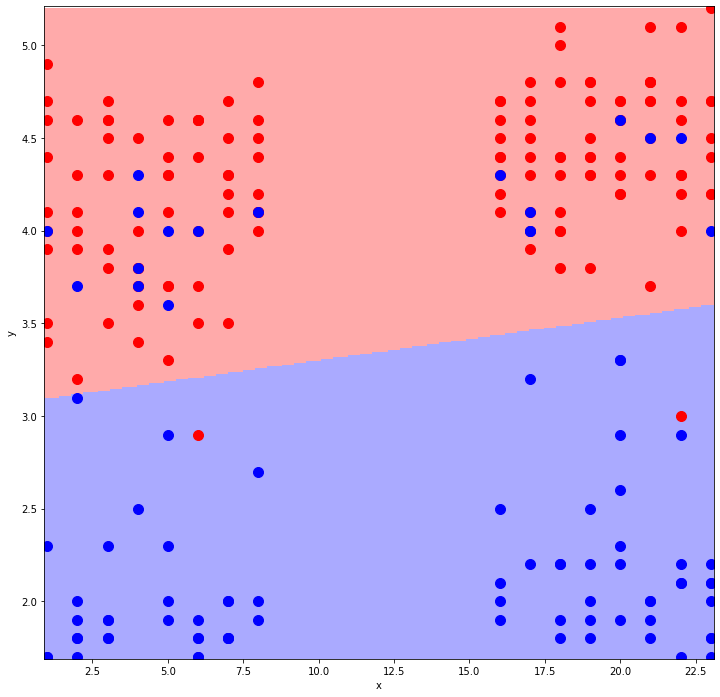

In [17]:
process_with_solver(X, y, 'gradient', 0.1, 0.01)

alpha = 0.0001 f-score = 0.8614269427040556
alpha = 0.001 f-score = 0.8686465429488684
alpha = 0.01 f-score = 0.8621591339238399
alpha = 0.1 f-score = 0.6128888888888889
alpha = 1.0 f-score = 0.38873379099923727
Best params: 0.001 0.8686465429488684
time = 205179 microseconds
errors = 11 steps = 6


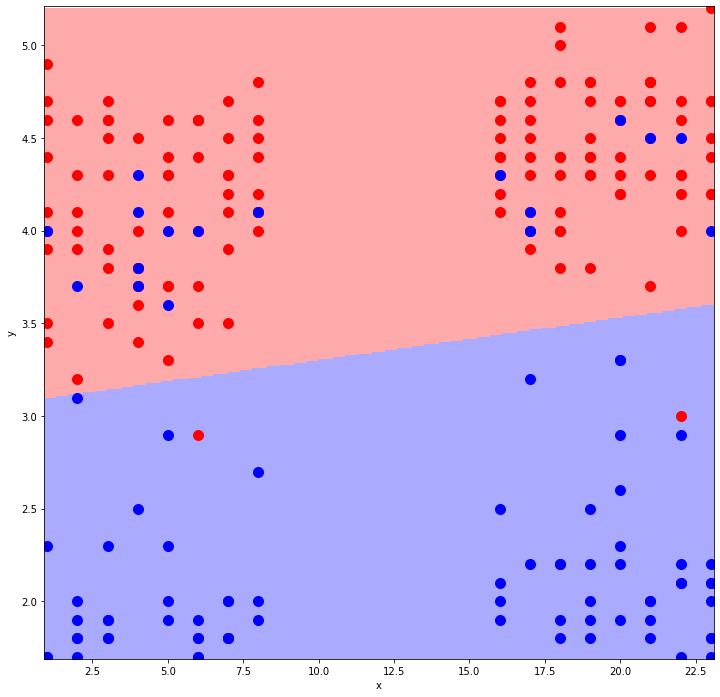

In [18]:
process_with_solver(X, y, 'newton', 0.1, 0.01)